In [1]:
# Steps 
# 1. Get the dataset (Web scraping)
# 2. Clean your dataset
# 3. Train-test split (12 features and 1 target(winning team(Home/Away/draw)))
# 4. Train 4 different classifiers - Logistic, SVM, XGBoost, Random Forest
# 5. Given an away and home team, Use the best classifier to predict who will win 

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

## Parsing the html content of the page using requests

In [3]:
EPL_url = "https://fbref.com/en/comps/9/Premier-League-Stats" 
EPL_response_html = requests.get(EPL_url)
EPL_response_html

<Response [200]>

## Parsing the a tags of each team using Beautiful soup
- We need them because we need the stats of each team

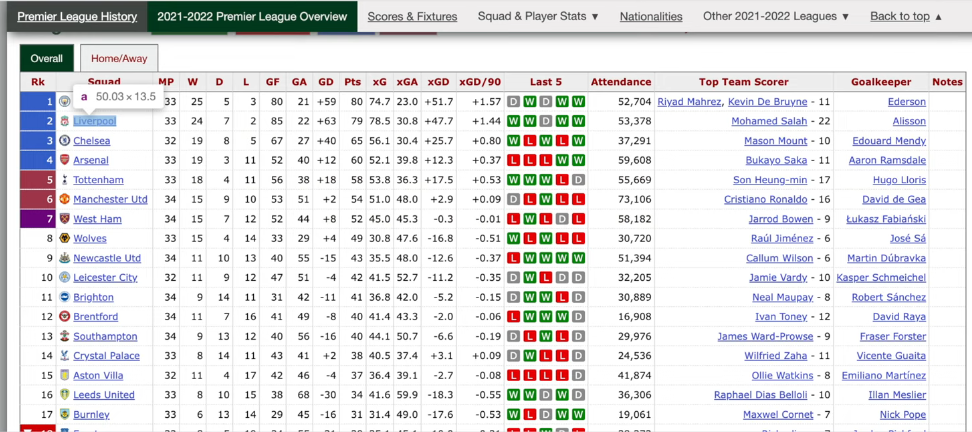

In [4]:
soup = BeautifulSoup(EPL_response_html.content, 'html.parser')     # Create a soup object
# Select the stats table
points_table = soup.find('table', {'class': 'stats_table'})

# Find all the <a> tags inside the table
a_tags = points_table.find_all('a')

# Scrape the team urls from the relevant <a> tags (which contains '/squads' in it)
team_urls = []
for a_tag in a_tags:
    href = a_tag.get("href")
    if '/squads/' in href:
        team_urls.append('https://fbref.com' + href)         # href looks like "/en/squads/822bd0ba/Liverpool-Stats"
      
    
# e.g url is "https://fbref.com/en/squads/822bd0ba/Liverpool-Stats"
team_urls

['https://fbref.com/en/squads/822bd0ba/Liverpool-Stats',
 'https://fbref.com/en/squads/b8fd03ef/Manchester-City-Stats',
 'https://fbref.com/en/squads/18bb7c10/Arsenal-Stats',
 'https://fbref.com/en/squads/8602292d/Aston-Villa-Stats',
 'https://fbref.com/en/squads/361ca564/Tottenham-Hotspur-Stats',
 'https://fbref.com/en/squads/19538871/Manchester-United-Stats',
 'https://fbref.com/en/squads/7c21e445/West-Ham-United-Stats',
 'https://fbref.com/en/squads/b2b47a98/Newcastle-United-Stats',
 'https://fbref.com/en/squads/d07537b9/Brighton-and-Hove-Albion-Stats',
 'https://fbref.com/en/squads/8cec06e1/Wolverhampton-Wanderers-Stats',
 'https://fbref.com/en/squads/cff3d9bb/Chelsea-Stats',
 'https://fbref.com/en/squads/fd962109/Fulham-Stats',
 'https://fbref.com/en/squads/4ba7cbea/Bournemouth-Stats',
 'https://fbref.com/en/squads/47c64c55/Crystal-Palace-Stats',
 'https://fbref.com/en/squads/cd051869/Brentford-Stats',
 'https://fbref.com/en/squads/d3fd31cc/Everton-Stats',
 'https://fbref.com/en/s

## Extracting the Match stats using pandas 

In [5]:
team_url = team_urls[0]
team_match_data = requests.get(team_url)     # response HTML - team_match_data.text

In [6]:
# Scan all of the tables in the page and if the string matches "Scores & Fixtures", then get that specific table 
matches = pd.read_html(team_match_data.text, match="Scores & Fixtures")
matches_df = matches[0]
matches_df.head()
matches_df.columns

Index(['Date', 'Time', 'Comp', 'Round', 'Day', 'Venue', 'Result', 'GF', 'GA',
       'Opponent', 'xG', 'xGA', 'Poss', 'Attendance', 'Captain', 'Formation',
       'Referee', 'Match Report', 'Notes'],
      dtype='object')

## 2) Get the match shooting stats to extract more match features

In [7]:
soup = BeautifulSoup(team_match_data.text)
all_links = soup.find_all('a')
all_links = [link.get("href") for link in all_links]
shooting_link = ['https://fbref.com' + link for link in all_links if link and 'all_comps/shooting/' in link]
shooting_link

['https://fbref.com/en/squads/822bd0ba/2023-2024/matchlogs/all_comps/shooting/Liverpool-Match-Logs-All-Competitions',
 'https://fbref.com/en/squads/822bd0ba/2023-2024/matchlogs/all_comps/shooting/Liverpool-Match-Logs-All-Competitions',
 'https://fbref.com/en/squads/822bd0ba/2023-2024/matchlogs/all_comps/shooting/Liverpool-Match-Logs-All-Competitions',
 'https://fbref.com/en/squads/822bd0ba/2023-2024/matchlogs/all_comps/shooting/Liverpool-Match-Logs-All-Competitions']

In [8]:
shooting_data = requests.get(shooting_link[0])        
shooting_df = pd.read_html(shooting_data.text)[0]
shooting_df.head()

For Liverpool                                                             \
           Date   Time            Comp        Round  Day Venue Result   GF   
0    2023-08-13  16:30  Premier League  Matchweek 1  Sun  Away      D  1.0   
1    2023-08-19  15:00  Premier League  Matchweek 2  Sat  Home      W  3.0   
2    2023-08-27  16:30  Premier League  Matchweek 3  Sun  Away      W  2.0   
3    2023-09-03  14:00  Premier League  Matchweek 4  Sun  Home      W  3.0   
4    2023-09-16  12:30  Premier League  Matchweek 5  Sat  Away      W  3.0   

                       ... Standard               Expected                    \
    GA       Opponent  ...     Dist   FK PK PKatt       xG npxG npxG/Sh G-xG   
0  1.0        Chelsea  ...     17.8  0.0  0     0      1.3  1.3    0.10 -0.3   
1  1.0    Bournemouth  ...     16.8  1.0  0     1      3.0  2.1    0.09  0.0   
2  1.0  Newcastle Utd  ...     17.2  1.0  0     0      0.9  0.9    0.10  1.1   
3  0.0    Aston Villa  ...     14.7  0.0  0     0      2.5  2.5    0.15 -0.5   
4  1.0         Wolves  ...     15.8  0.0  0     0      2.5  2.5    0.16 -0.5   

          Unnamed: 25_level_0  
  np:G-xG        Match Report  
0    -0.3        Match Report  
1     0.9        Match Report  
2     1.1        Match Report  
3    -0.5        Match Report  
4    -0.5        Match Report  

[5 rows x 26 columns]

## 3) Get the match passing stats to extract more match features

In [9]:
passing_link = ['https://fbref.com' + link for link in all_links if link and 'all_comps/passing/' in link]
passing_link

['https://fbref.com/en/squads/822bd0ba/2023-2024/matchlogs/all_comps/passing/Liverpool-Match-Logs-All-Competitions',
 'https://fbref.com/en/squads/822bd0ba/2023-2024/matchlogs/all_comps/passing/Liverpool-Match-Logs-All-Competitions',
 'https://fbref.com/en/squads/822bd0ba/2023-2024/matchlogs/all_comps/passing/Liverpool-Match-Logs-All-Competitions',
 'https://fbref.com/en/squads/822bd0ba/2023-2024/matchlogs/all_comps/passing/Liverpool-Match-Logs-All-Competitions']

In [10]:
passing_data = requests.get(passing_link[0])        
passing_df = pd.read_html(passing_data.text)[0]
passing_df.head()

For Liverpool                                                             \
           Date   Time            Comp        Round  Day Venue Result   GF   
0    2023-08-13  16:30  Premier League  Matchweek 1  Sun  Away      D  1.0   
1    2023-08-19  15:00  Premier League  Matchweek 2  Sat  Home      W  3.0   
2    2023-08-27  16:30  Premier League  Matchweek 3  Sun  Away      W  2.0   
3    2023-09-03  14:00  Premier League  Matchweek 4  Sun  Home      W  3.0   
4    2023-09-16  12:30  Premier League  Matchweek 5  Sat  Away      W  3.0   

                       ...  Long Unnamed: 24_level_0 Unnamed: 25_level_0  \
    GA       Opponent  ...  Cmp%                 Ast                 xAG   
0  1.0        Chelsea  ...  46.7                   1                 1.2   
1  1.0    Bournemouth  ...  60.9                   0                 0.9   
2  1.0  Newcastle Utd  ...  41.8                   1                 0.8   
3  0.0    Aston Villa  ...  64.3                   2                 1.7   
4  1.0         Wolves  ...  64.8                   2                 2.2   

  Unnamed: 26_level_0 Unnamed: 27_level_0 Unnamed: 28_level_0  \
                   xA                  KP                 1/3   
0                 0.8                10.0                25.0   
1                 1.0                15.0                30.0   
2                 0.7                 7.0                19.0   
3                 0.9                13.0                27.0   
4                 2.7                13.0                58.0   

  Unnamed: 29_level_0 Unnamed: 30_level_0 Unnamed: 31_level_0  \
                  PPA               CrsPA                PrgP   
0                 8.0                 2.0                34.0   
1                10.0                 0.0                40.0   
2                 6.0                 0.0                26.0   
3                 9.0                 1.0                41.0   
4                13.0                 4.0                73.0   

  Unnamed: 32_level_0  
         Match Report  
0        Match Report  
1        Match Report  
2        Match Report  
3        Match Report  
4        Match Report  

[5 rows x 33 columns]

## 4) Get Goal and shot creation stats

In [11]:
gca_link = ['https://fbref.com' + link for link in all_links if link and 'all_comps/gca/' in link]
gca_link

['https://fbref.com/en/squads/822bd0ba/2023-2024/matchlogs/all_comps/gca/Liverpool-Match-Logs-All-Competitions',
 'https://fbref.com/en/squads/822bd0ba/2023-2024/matchlogs/all_comps/gca/Liverpool-Match-Logs-All-Competitions',
 'https://fbref.com/en/squads/822bd0ba/2023-2024/matchlogs/all_comps/gca/Liverpool-Match-Logs-All-Competitions',
 'https://fbref.com/en/squads/822bd0ba/2023-2024/matchlogs/all_comps/gca/Liverpool-Match-Logs-All-Competitions']

In [12]:
gca_data = requests.get(gca_link[0])        
gca_df = pd.read_html(gca_data.text)[0]
gca_df.head()

For Liverpool                                                             \
           Date   Time            Comp        Round  Day Venue Result   GF   
0    2023-08-13  16:30  Premier League  Matchweek 1  Sun  Away      D  1.0   
1    2023-08-19  15:00  Premier League  Matchweek 2  Sat  Home      W  3.0   
2    2023-08-27  16:30  Premier League  Matchweek 3  Sun  Away      W  2.0   
3    2023-09-03  14:00  Premier League  Matchweek 4  Sun  Home      W  3.0   
4    2023-09-16  12:30  Premier League  Matchweek 5  Sat  Away      W  3.0   

                       ... SCA Types      GCA Types                         \
    GA       Opponent  ...       Fld  Def       GCA PassLive PassDead   TO   
0  1.0        Chelsea  ...       0.0  0.0       2.0      2.0      0.0  0.0   
1  1.0    Bournemouth  ...       2.0  1.0       4.0      1.0      0.0  1.0   
2  1.0  Newcastle Utd  ...       2.0  1.0       3.0      3.0      0.0  0.0   
3  0.0    Aston Villa  ...       1.0  0.0       2.0      0.0      1.0  0.0   
4  1.0         Wolves  ...       0.0  0.0       4.0      4.0      0.0  0.0   

                 Unnamed: 24_level_0  
    Sh  Fld  Def        Match Report  
0  0.0  0.0  0.0        Match Report  
1  2.0  0.0  0.0        Match Report  
2  0.0  0.0  0.0        Match Report  
3  1.0  0.0  0.0        Match Report  
4  0.0  0.0  0.0        Match Report  

[5 rows x 25 columns]

## 5) Miscellaneous stats

In [13]:
misc_link = ['https://fbref.com' + link for link in all_links if link and 'all_comps/misc/' in link]
misc_link

['https://fbref.com/en/squads/822bd0ba/2023-2024/matchlogs/all_comps/misc/Liverpool-Match-Logs-All-Competitions',
 'https://fbref.com/en/squads/822bd0ba/2023-2024/matchlogs/all_comps/misc/Liverpool-Match-Logs-All-Competitions',
 'https://fbref.com/en/squads/822bd0ba/2023-2024/matchlogs/all_comps/misc/Liverpool-Match-Logs-All-Competitions',
 'https://fbref.com/en/squads/822bd0ba/2023-2024/matchlogs/all_comps/misc/Liverpool-Match-Logs-All-Competitions']

In [14]:
misc_data = requests.get(misc_link[0])        
misc_df = pd.read_html(misc_data.text)[0]
misc_df.head()

For Liverpool                                                             \
           Date   Time            Comp        Round  Day Venue Result   GF   
0    2023-08-13  16:30  Premier League  Matchweek 1  Sun  Away      D  1.0   
1    2023-08-19  15:00  Premier League  Matchweek 2  Sat  Home      W  3.0   
2    2023-08-27  16:30  Premier League  Matchweek 3  Sun  Away      W  2.0   
3    2023-09-03  14:00  Premier League  Matchweek 4  Sun  Home      W  3.0   
4    2023-09-16  12:30  Premier League  Matchweek 5  Sat  Away      W  3.0   

                       ... Performance                           Aerial Duels  \
    GA       Opponent  ...         Int TklW PKwon PKcon OG Recov          Won   
0  1.0        Chelsea  ...          10    9   0.0   0.0  0  62.0          6.0   
1  1.0    Bournemouth  ...          11   11   1.0   0.0  0  58.0         19.0   
2  1.0  Newcastle Utd  ...           8    7   0.0   0.0  0  42.0          8.0   
3  0.0    Aston Villa  ...           8    9   0.0   0.0  0  56.0          8.0   
4  1.0         Wolves  ...           9   16   0.0   0.0  0  57.0         11.0   

              Unnamed: 26_level_0  
   Lost  Won%        Match Report  
0  11.0  35.3        Match Report  
1  11.0  63.3        Match Report  
2   9.0  47.1        Match Report  
3   2.0  80.0        Match Report  
4   7.0  61.1        Match Report  

[5 rows x 27 columns]

## Data cleaning
### Drop the outer index from all dfs

In [15]:
# Drop the outer index
shooting_df.columns = shooting_df.columns.droplevel()
passing_df.columns = passing_df.columns.droplevel()
gca_df.columns = gca_df.columns.droplevel()
misc_df.columns = misc_df.columns.droplevel()
misc_df.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,Int,TklW,PKwon,PKcon,OG,Recov,Won,Lost,Won%,Match Report
0,2023-08-13,16:30,Premier League,Matchweek 1,Sun,Away,D,1.0,1.0,Chelsea,...,10,9,0.0,0.0,0,62.0,6.0,11.0,35.3,Match Report
1,2023-08-19,15:00,Premier League,Matchweek 2,Sat,Home,W,3.0,1.0,Bournemouth,...,11,11,1.0,0.0,0,58.0,19.0,11.0,63.3,Match Report
2,2023-08-27,16:30,Premier League,Matchweek 3,Sun,Away,W,2.0,1.0,Newcastle Utd,...,8,7,0.0,0.0,0,42.0,8.0,9.0,47.1,Match Report
3,2023-09-03,14:00,Premier League,Matchweek 4,Sun,Home,W,3.0,0.0,Aston Villa,...,8,9,0.0,0.0,0,56.0,8.0,2.0,80.0,Match Report
4,2023-09-16,12:30,Premier League,Matchweek 5,Sat,Away,W,3.0,1.0,Wolves,...,9,16,0.0,0.0,0,57.0,11.0,7.0,61.1,Match Report


### Merge the dataframes on "date"

In [16]:
# Merging the matches and shooting dataframe
print(shooting_df.shape)
print(matches_df.shape)
team_data_df = matches_df.merge(shooting_df[["Date", "Sh", "SoT", "SoT%", "G/Sh", "G/SoT", "Dist", "FK", "PK", "PKatt"]], on="Date")
print(team_data_df.shape)
team_data_df.head()

(44, 26)
(56, 19)
(43, 28)


,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,Notes,Sh,SoT,SoT%,G/Sh,G/SoT,Dist,FK,PK,PKatt
0,2023-08-13,16:30,Premier League,Matchweek 1,Sun,Away,D,1.0,1.0,Chelsea,...,NaN,13,1,7.7,0.08,1.00,17.8,0.0,0,0
1,2023-08-19,15:00,Premier League,Matchweek 2,Sat,Home,W,3.0,1.0,Bournemouth,...,NaN,25,9,36.0,0.12,0.33,16.8,1.0,0,1
2,2023-08-27,16:30,Premier League,Matchweek 3,Sun,Away,W,2.0,1.0,Newcastle Utd,...,NaN,9,4,44.4,0.22,0.50,17.2,1.0,0,0
3,2023-09-03,14:00,Premier League,Matchweek 4,Sun,Home,W,3.0,0.0,Aston Villa,...,NaN,17,4,23.5,0.12,0.50,14.7,0.0,0,0
4,2023-09-16,12:30,Premier League,Matchweek 5,Sat,Away,W,3.0,1.0,Wolves,...,NaN,16,5,31.3,0.13,0.40,15.8,0.0,0,0


In [17]:
all_dfs = [shooting_df, passing_df, gca_df, misc_df]
columns_dict = {
    "shooting_df": ["Date", "Sh", "SoT", "SoT%", "G/Sh", "G/SoT", "Dist", "FK", "PK", "PKatt"],
    "passing_df": ["Date", "Cmp","Att","Cmp%","TotDist","PrgDist", "KP","1/3","PPA", "CrsPA", "PrgP"],
    "gca_df": ["Date", "SCA", "GCA"],
    "misc_df": ["Date", "Crs","Int","TklW", "Recov"]
}

# Initialize the merged DataFrame with the first DataFrame
team_data_df = matches_df.merge(all_dfs[0][columns_dict["shooting_df"]], on="Date")

for i in range(1, len(all_dfs)):
    try:
        # Merge the current DataFrame with the existing team_data_df
        team_data_df = team_data_df.merge(all_dfs[i][columns_dict[list(columns_dict.keys())[i]]], on="Date")
    except ValueError:
        continue

In [18]:
team_data_df.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,1/3,PPA,CrsPA,PrgP,SCA,GCA,Crs,Int,TklW,Recov
0,2023-08-13,16:30,Premier League,Matchweek 1,Sun,Away,D,1.0,1.0,Chelsea,...,25.0,8.0,2.0,34.0,24.0,2.0,12,10,9,62.0
1,2023-08-19,15:00,Premier League,Matchweek 2,Sat,Home,W,3.0,1.0,Bournemouth,...,30.0,10.0,0.0,40.0,40.0,4.0,16,11,11,58.0
2,2023-08-27,16:30,Premier League,Matchweek 3,Sun,Away,W,2.0,1.0,Newcastle Utd,...,19.0,6.0,0.0,26.0,16.0,3.0,16,8,7,42.0
3,2023-09-03,14:00,Premier League,Matchweek 4,Sun,Home,W,3.0,0.0,Aston Villa,...,27.0,9.0,1.0,41.0,32.0,2.0,13,8,9,56.0
4,2023-09-16,12:30,Premier League,Matchweek 5,Sat,Away,W,3.0,1.0,Wolves,...,58.0,13.0,4.0,73.0,30.0,4.0,18,9,16,57.0


## Scraping data for for multiple season and teams 

In [19]:
years = [2023, 2022, 2021]
all_matches = []               # list of dfs, each item in the list is a df of a specific team in a specific season

EPL_url = "https://fbref.com/en/comps/9/Premier-League-Stats" 

for year in years:
    EPL_response_html = requests.get(EPL_url)
    soup = BeautifulSoup(EPL_response_html.content, 'html.parser')     # Create a soup object
    table = soup.find('table', {'class': 'stats_table'})

    # Find all the <a> tags inside the table
    a_tags = table.find_all('a')

    # Scrape the team urls FROM THE {CURRENT SEASON} from the relevant <a> tags (which contains '/squads' in it)
    team_urls = []
    for a_tag in a_tags:
        href = a_tag.get("href")
        if '/squads/' in href:
            team_urls.append('https://fbref.com' + href)
            
        
    for team_url in team_urls:
        team_name = team_url.split('/')[-1].replace('-Stats', '').replace('-', ' ')
        
        team_match_data = requests.get(team_url)         # response HTML
             
        matches = pd.read_html(team_match_data.text, match="Scores & Fixtures")
        matches_df = matches[0]
        
        # SCRAPE THE SHOOTING, PASSING, MISC STATS ....
        soup = BeautifulSoup(team_match_data.text)
        all_links = soup.find_all('a')
        all_links = [link.get("href") for link in all_links]
        shooting_link = ['https://fbref.com' + link for link in all_links if link and 'all_comps/shooting/' in link]
        passing_link = ['https://fbref.com' + link for link in all_links if link and 'all_comps/passing/' in link]
        gca_link = ['https://fbref.com' + link for link in all_links if link and 'all_comps/gca/' in link]
        misc_link = ['https://fbref.com' + link for link in all_links if link and 'all_comps/misc/' in link]

        
        shooting_data = requests.get(shooting_link[0])
        passing_data = requests.get(passing_link[0])        
        misc_data = requests.get(misc_link[0])  
        gca_data = requests.get(gca_link[0])        

#         print(shooting_data)
#        Read the respective table from the corresponding pages into dfs
        shooting_df = pd.read_html(shooting_data.text, match="Shooting")[0]
        passing_df = pd.read_html(passing_data.text, match="Passing")[0]
        misc_df = pd.read_html(misc_data.text, match="Miscellaneous Stats")[0]
        gca_df = pd.read_html(gca_data.text)[0]
        
        # Drop the outer index from the multi-level index
        shooting_df.columns = shooting_df.columns.droplevel()
        passing_df.columns = passing_df.columns.droplevel()
        gca_df.columns = gca_df.columns.droplevel()
        misc_df.columns = misc_df.columns.droplevel()

        
        # MERGE THEM (Skipping over those teams whose shooting datas aren't available)
        # List of shooting DataFrames and their corresponding column names to be merged
        all_dfs = [shooting_df, passing_df, gca_df, misc_df]
        columns_dict = {
            "shooting_df": ["Date", "Sh", "SoT", "SoT%", "G/Sh", "G/SoT", "Dist", "FK", "PK", "PKatt"],
            "passing_df": ["Date", "Cmp","Att","Cmp%","TotDist","PrgDist", "KP","1/3","PPA", "CrsPA", "PrgP"],
            "gca_df": ["Date", "SCA", "GCA"],
            "misc_df": ["Date", "Crs","Int","TklW", "Recov"]
        }

        try:
            team_data_df = matches_df.merge(all_dfs[0][columns_dict["shooting_df"]], on="Date")
        except ValueError:
            continue


        for i in range(1, len(all_dfs)):
            try:
                # Merge the current DataFrame with the existing team_data_df
                team_data_df = team_data_df.merge(all_dfs[i][columns_dict[list(columns_dict.keys())[i]]], on="Date")
            except ValueError:
                continue
            
        # Filter out non Premier league matches
        team_data_df = team_data_df[team_data_df["Comp"] == "Premier League"]
        team_data_df["Season"] = year
        team_data_df["Team Name"] = team_name
        
        all_matches.append(team_data_df)
        print(team_name)
        print(team_data_df.head())
        
        # Wait for 2 seconds before retrying
        time.sleep(10)   
 
    EPL_response_html = requests.get(EPL_url)
    soup = BeautifulSoup(EPL_response_html.content, 'html.parser')     # Create a soup object
    
    # Get the previous season's page URL to scrape data from :- 
    previous_season_href = soup.select("a.prev")[0].get("href")
    EPL_url = 'https://fbref.com' + previous_season_href
    

Liverpool
         Date   Time            Comp        Round  Day Venue Result   GF   GA  \
0  2023-08-13  16:30  Premier League  Matchweek 1  Sun  Away      D  1.0  1.0   
1  2023-08-19  15:00  Premier League  Matchweek 2  Sat  Home      W  3.0  1.0   
2  2023-08-27  16:30  Premier League  Matchweek 3  Sun  Away      W  2.0  1.0   
3  2023-09-03  14:00  Premier League  Matchweek 4  Sun  Home      W  3.0  0.0   
4  2023-09-16  12:30  Premier League  Matchweek 5  Sat  Away      W  3.0  1.0   

        Opponent  ...  CrsPA  PrgP   SCA  GCA Crs Int TklW Recov Season  \
0        Chelsea  ...    2.0  34.0  24.0  2.0  12  10    9  62.0   2023   
1    Bournemouth  ...    0.0  40.0  40.0  4.0  16  11   11  58.0   2023   
2  Newcastle Utd  ...    0.0  26.0  16.0  3.0  16   8    7  42.0   2023   
3    Aston Villa  ...    1.0  41.0  32.0  2.0  13   8    9  56.0   2023   
4         Wolves  ...    4.0  73.0  30.0  4.0  18   9   16  57.0   2023   

   Team Name  
0  Liverpool  
1  Liverpool  
2  Live

Brighton and Hove Albion
         Date   Time            Comp        Round  Day Venue Result   GF   GA  \
0  2023-08-12  15:00  Premier League  Matchweek 1  Sat  Home      W  4.0  1.0   
1  2023-08-19  15:00  Premier League  Matchweek 2  Sat  Away      W  4.0  1.0   
2  2023-08-26  17:30  Premier League  Matchweek 3  Sat  Home      L  1.0  3.0   
3  2023-09-02  17:30  Premier League  Matchweek 4  Sat  Home      W  3.0  1.0   
4  2023-09-16  15:00  Premier League  Matchweek 5  Sat  Away      W  3.0  1.0   

         Opponent  ...  CrsPA   PrgP   SCA  GCA Crs Int TklW Recov Season  \
0      Luton Town  ...    5.0   64.0  48.0  6.0  23   4   10  50.0   2023   
1          Wolves  ...    0.0   38.0  32.0  8.0   9  10   17  59.0   2023   
2        West Ham  ...    6.0  109.0  47.0  2.0  41   6    6  50.0   2023   
3   Newcastle Utd  ...    1.0   33.0  27.0  5.0   9  11    3  46.0   2023   
4  Manchester Utd  ...    2.0   27.0  19.0  6.0   4  10    9  53.0   2023   

                  Team Na

Nottingham Forest
         Date   Time            Comp        Round  Day Venue Result GF GA  \
0  2023-08-12  12:30  Premier League  Matchweek 1  Sat  Away      L  1  2   
1  2023-08-18  19:45  Premier League  Matchweek 2  Fri  Home      W  2  1   
2  2023-08-26  15:00  Premier League  Matchweek 3  Sat  Away      L  2  3   
4  2023-09-02  15:00  Premier League  Matchweek 4  Sat  Away      W  1  0   
5  2023-09-18  19:45  Premier League  Matchweek 5  Mon  Home      D  1  1   

         Opponent  ...  CrsPA  PrgP   SCA  GCA Crs Int TklW Recov Season  \
0         Arsenal  ...    0.0  14.0  10.0  2.0   6   8   10  34.0   2023   
1   Sheffield Utd  ...    2.0  40.0  28.0  4.0  21  14   11  54.0   2023   
2  Manchester Utd  ...    1.0  14.0  16.0  4.0  12  14   13  54.0   2023   
4         Chelsea  ...    0.0  15.0  14.0  2.0   4   9   11  54.0   2023   
5         Burnley  ...    1.0  33.0  28.0  2.0  18   6    9  44.0   2023   

           Team Name  
0  Nottingham Forest  
1  Nottingham Fo

Liverpool
         Date   Time            Comp        Round  Day Venue Result GF GA  \
1  2022-08-06  12:30  Premier League  Matchweek 1  Sat  Away      D  2  2   
2  2022-08-15  20:00  Premier League  Matchweek 2  Mon  Home      D  1  1   
3  2022-08-22  20:00  Premier League  Matchweek 3  Mon  Away      L  1  2   
4  2022-08-27  15:00  Premier League  Matchweek 4  Sat  Home      W  9  0   
5  2022-08-31  20:00  Premier League  Matchweek 5  Wed  Home      W  2  1   

         Opponent  ...  CrsPA  PrgP   SCA   GCA Crs Int TklW Recov Season  \
1          Fulham  ...    2.0  53.0  20.0   4.0  18  10    9  63.0   2022   
2  Crystal Palace  ...    4.0  86.0  45.0   2.0  29  13   15  77.0   2022   
3  Manchester Utd  ...    2.0  57.0  30.0   1.0  23   6   11  60.0   2022   
4     Bournemouth  ...    4.0  74.0  33.0  14.0  20   9   10  65.0   2022   
5   Newcastle Utd  ...    4.0  73.0  40.0   4.0  41   6    5  59.0   2022   

   Team Name  
1  Liverpool  
2  Liverpool  
3  Liverpool  
4  L

Wolverhampton Wanderers
         Date   Time            Comp        Round  Day Venue Result GF GA  \
0  2022-08-06  15:00  Premier League  Matchweek 1  Sat  Away      L  1  2   
1  2022-08-13  15:00  Premier League  Matchweek 2  Sat  Home      D  0  0   
2  2022-08-20  12:30  Premier League  Matchweek 3  Sat  Away      L  0  1   
4  2022-08-28  14:00  Premier League  Matchweek 4  Sun  Home      D  1  1   
5  2022-08-31  19:30  Premier League  Matchweek 5  Wed  Away      D  0  0   

        Opponent  ...  CrsPA  PrgP   SCA  GCA Crs Int TklW Recov Season  \
0   Leeds United  ...    3.0  44.0  27.0  2.0  20  14   11  65.0   2022   
1         Fulham  ...    3.0  29.0  13.0  0.0  19   8   11  57.0   2022   
2      Tottenham  ...    1.0  44.0  36.0  0.0  19   6   12  50.0   2022   
4  Newcastle Utd  ...    3.0  22.0  13.0  2.0  14   4   10  53.0   2022   
5    Bournemouth  ...    5.0  83.0  32.0  0.0  27   6   11  70.0   2022   

                 Team Name  
0  Wolverhampton Wanderers  
1  W

Manchester City
         Date   Time            Comp        Round  Day Venue Result GF GA  \
1  2021-08-15  16:30  Premier League  Matchweek 1  Sun  Away      L  0  1   
2  2021-08-21  15:00  Premier League  Matchweek 2  Sat  Home      W  5  0   
3  2021-08-28  12:30  Premier League  Matchweek 3  Sat  Home      W  5  0   
4  2021-09-11  15:00  Premier League  Matchweek 4  Sat  Away      W  1  0   
6  2021-09-18  15:00  Premier League  Matchweek 5  Sat  Home      D  0  0   

         Opponent  ...  CrsPA  PrgP   SCA   GCA Crs Int TklW Recov Season  \
1       Tottenham  ...    2.0  58.0  35.0   0.0  30   3   11  53.0   2021   
2    Norwich City  ...    0.0  75.0  28.0   7.0  26   6    8  38.0   2021   
3         Arsenal  ...    6.0  69.0  49.0  10.0  30   4   10  45.0   2021   
4  Leicester City  ...    4.0  76.0  42.0   1.0  31   5    7  53.0   2021   
6     Southampton  ...    3.0  42.0  31.0   0.0  23   8   10  51.0   2021   

         Team Name  
1  Manchester City  
2  Manchester Ci

Brighton and Hove Albion
         Date   Time            Comp        Round  Day Venue Result GF GA  \
0  2021-08-14  15:00  Premier League  Matchweek 1  Sat  Away      W  2  1   
1  2021-08-21  17:30  Premier League  Matchweek 2  Sat  Home      W  2  0   
3  2021-08-28  15:00  Premier League  Matchweek 3  Sat  Home      L  0  2   
4  2021-09-11  15:00  Premier League  Matchweek 4  Sat  Away      W  1  0   
5  2021-09-19  14:00  Premier League  Matchweek 5  Sun  Home      W  2  1   

         Opponent  ...  CrsPA  PrgP   SCA  GCA Crs Int TklW Recov Season  \
0         Burnley  ...    2.0  39.0  23.0  4.0  14   6    9  45.0   2021   
1         Watford  ...    0.0  43.0  23.0  4.0  20   8   11  52.0   2021   
3         Everton  ...    2.0  51.0  27.0  0.0  12  10   16  55.0   2021   
4       Brentford  ...    0.0  40.0   8.0  2.0  11  12   11  50.0   2021   
5  Leicester City  ...    0.0  25.0  23.0  3.0  15  16   13  44.0   2021   

                  Team Name  
0  Brighton and Hove Albi

Leeds United
         Date   Time            Comp        Round  Day Venue Result GF GA  \
0  2021-08-14  12:30  Premier League  Matchweek 1  Sat  Away      L  1  5   
1  2021-08-21  15:00  Premier League  Matchweek 2  Sat  Home      D  2  2   
3  2021-08-29  14:00  Premier League  Matchweek 3  Sun  Away      D  1  1   
4  2021-09-12  16:30  Premier League  Matchweek 4  Sun  Home      L  0  3   
5  2021-09-17  20:00  Premier League  Matchweek 5  Fri  Away      D  1  1   

         Opponent  ...  CrsPA  PrgP   SCA  GCA Crs Int TklW Recov Season  \
0  Manchester Utd  ...    3.0  32.0  18.0  2.0  14  14   13  53.0   2021   
1         Everton  ...    1.0  54.0  30.0  4.0  25   9    9  52.0   2021   
3         Burnley  ...    1.0  51.0  22.0  1.0  27   8   10  65.0   2021   
4       Liverpool  ...    2.0  29.0  16.0  0.0  19  10    8  45.0   2021   
5   Newcastle Utd  ...    2.0  62.0  38.0  2.0  23   6    9  46.0   2021   

      Team Name  
0  Leeds United  
1  Leeds United  
3  Leeds Unit

In [20]:
match_df = pd.concat(all_matches)
match_df

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,CrsPA,PrgP,SCA,GCA,Crs,Int,TklW,Recov,Season,Team Name
0,2023-08-13,16:30,Premier League,Matchweek 1,Sun,Away,D,1.0,1.0,Chelsea,...,2.0,34.0,24.0,2.0,12.0,10.0,9.0,62.0,2023,Liverpool
1,2023-08-19,15:00,Premier League,Matchweek 2,Sat,Home,W,3.0,1.0,Bournemouth,...,0.0,40.0,40.0,4.0,16.0,11.0,11.0,58.0,2023,Liverpool
2,2023-08-27,16:30,Premier League,Matchweek 3,Sun,Away,W,2.0,1.0,Newcastle Utd,...,0.0,26.0,16.0,3.0,16.0,8.0,7.0,42.0,2023,Liverpool
3,2023-09-03,14:00,Premier League,Matchweek 4,Sun,Home,W,3.0,0.0,Aston Villa,...,1.0,41.0,32.0,2.0,13.0,8.0,9.0,56.0,2023,Liverpool
4,2023-09-16,12:30,Premier League,Matchweek 5,Sat,Away,W,3.0,1.0,Wolves,...,4.0,73.0,30.0,4.0,18.0,9.0,16.0,57.0,2023,Liverpool
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,2022-04-30,15:00,Premier League,Matchweek 35,Sat,Away,L,0,2,Aston Villa,...,0.0,26.0,17.0,0.0,10.0,14.0,6.0,49.0,2021,Norwich City
39,2022-05-08,14:00,Premier League,Matchweek 36,Sun,Home,L,0,4,West Ham,...,0.0,28.0,14.0,0.0,18.0,9.0,7.0,40.0,2021,Norwich City
40,2022-05-11,19:45,Premier League,Matchweek 21,Wed,Away,L,0,3,Leicester City,...,2.0,22.0,14.0,0.0,8.0,5.0,12.0,48.0,2021,Norwich City
41,2022-05-15,14:00,Premier League,Matchweek 37,Sun,Away,D,1,1,Wolves,...,0.0,19.0,20.0,1.0,7.0,9.0,14.0,44.0,2021,Norwich City


In [23]:
match_df.columns = [col.lower() for col in match_df.columns]
match_df.to_csv("all_matches3.csv")

In [24]:
import pandas as pd
match_df = pd.read_csv("all_matches3.csv")

In [26]:
match_df.columns

Index(['Unnamed: 0', 'date', 'time', 'comp', 'round', 'day', 'venue', 'result',
       'gf', 'ga', 'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain',
       'formation', 'referee', 'match report', 'notes', 'sh', 'sot', 'sot%',
       'g/sh', 'g/sot', 'dist', 'fk', 'pk', 'pkatt', 'cmp', 'cmp.1', 'cmp.2',
       'cmp.3', 'att', 'att.1', 'att.2', 'att.3', 'cmp%', 'cmp%.1', 'cmp%.2',
       'cmp%.3', 'totdist', 'prgdist', 'kp', '1/3', 'ppa', 'crspa', 'prgp',
       'sca', 'gca', 'crs', 'int', 'tklw', 'recov', 'season', 'team name'],
      dtype='object')

In [27]:
cols_to_delete = ['cmp.1', 'cmp.2', 'cmp.3', 'cmp%.1', 'cmp%.2', 'cmp%.3', 'att.1', 'att.2', 'att.3']

# Delete redundant columns
for col in cols_to_delete:
    del match_df[col]

In [28]:
match_df.head()

,Unnamed: 0,date,time,comp,round,day,venue,result,gf,ga,...,crspa,prgp,sca,gca,crs,int,tklw,recov,season,team name
0,0,2023-08-13,16:30,Premier League,Matchweek 1,Sun,Away,D,1.0,1.0,...,2.0,34.0,24.0,2.0,12.0,10.0,9.0,62.0,2023,Liverpool
1,1,2023-08-19,15:00,Premier League,Matchweek 2,Sat,Home,W,3.0,1.0,...,0.0,40.0,40.0,4.0,16.0,11.0,11.0,58.0,2023,Liverpool
2,2,2023-08-27,16:30,Premier League,Matchweek 3,Sun,Away,W,2.0,1.0,...,0.0,26.0,16.0,3.0,16.0,8.0,7.0,42.0,2023,Liverpool
3,3,2023-09-03,14:00,Premier League,Matchweek 4,Sun,Home,W,3.0,0.0,...,1.0,41.0,32.0,2.0,13.0,8.0,9.0,56.0,2023,Liverpool
4,4,2023-09-16,12:30,Premier League,Matchweek 5,Sat,Away,W,3.0,1.0,...,4.0,73.0,30.0,4.0,18.0,9.0,16.0,57.0,2023,Liverpool


In [29]:
match_df.to_csv("all_matches3.csv")

In [30]:
import pandas as pd
match_df = pd.read_csv("all_matches3.csv")
match_df.shape

(2056, 48)